In [2]:
from Dataset import VideoDataset
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from Loss import FocalLoss
from torchvision import models
import albumentations as A
from Model_Softmax import CNNLSTMWithAttention
from sklearn.metrics import confusion_matrix
from Dataset import preprocessing,transform_aug
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
plt.rcParams["font.family"] = "Times New Roman"


In [3]:
frame_width,frame_height = 250,150
x,y = 500,750
pt1_L = (x, y)
pt2_L = (x+frame_width, y+frame_height)
x,y = 1450,840
pt1_R = (x, y)
pt2_R = (x+frame_width, y+frame_height)
x,y = 1000,840
pt1_M = (x, y)
pt2_M = (x+frame_width, y+frame_height)
ROI_L, ROI_R, ROI_M = [pt1_L, pt2_L], [pt1_R, pt2_R], [pt1_M, pt2_M]

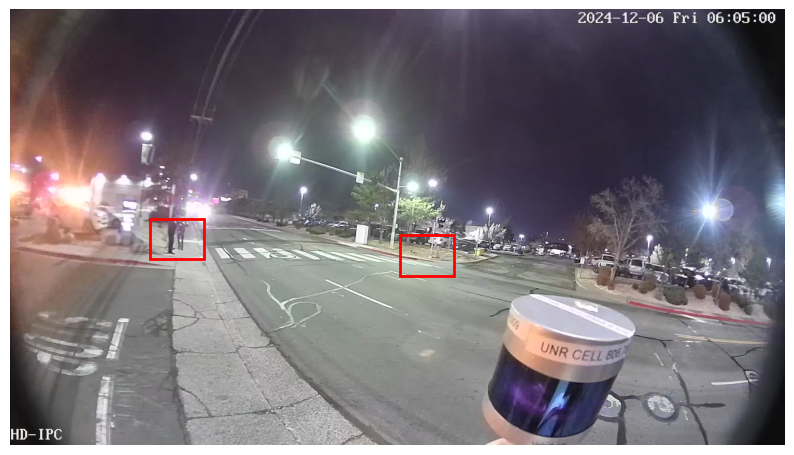

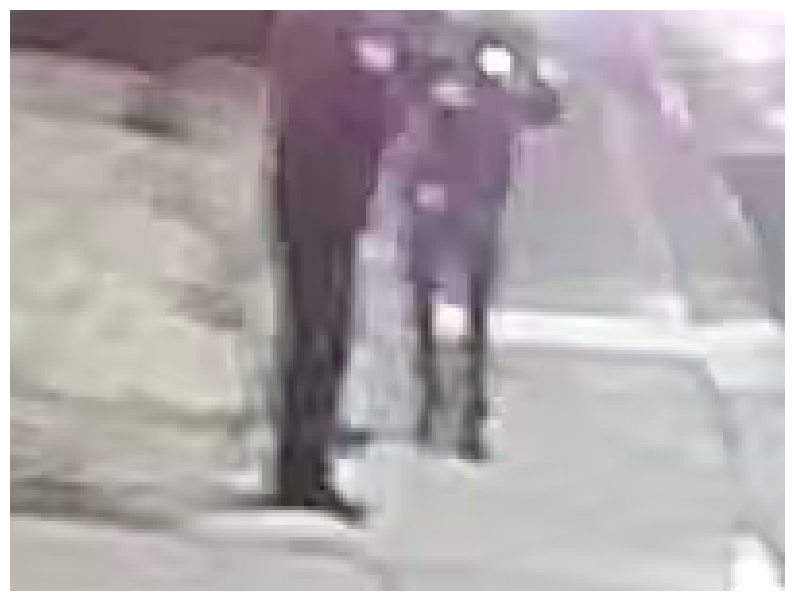

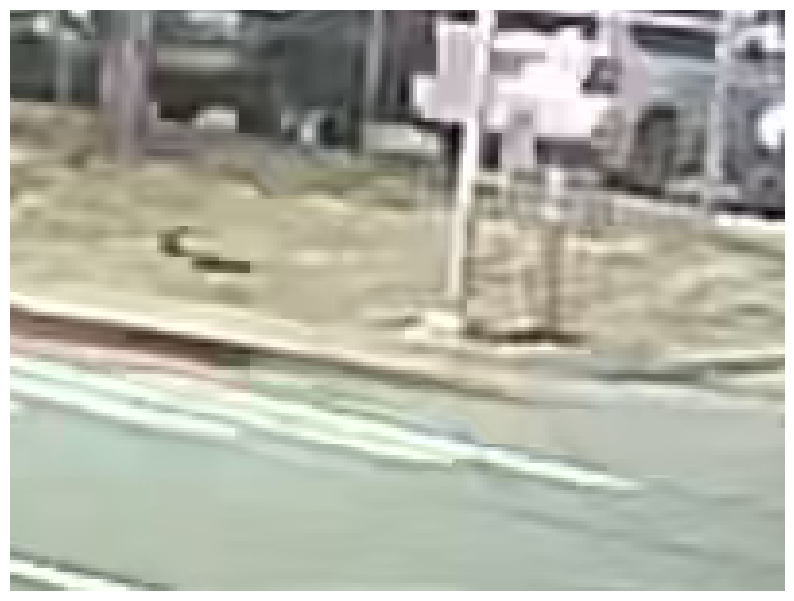

In [30]:
video_path = r'D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo\00_00_192.168.1.108_1_20241206_060500.avi'
cap = cv2.VideoCapture(video_path)
frame = cap.read()[1]
cap.release()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
# plot one frame
plt.figure(figsize=(10, 10))
plt.imshow(frame)
# draw the region of interests
plt.gca().add_patch(plt.Rectangle((pt1_L[0], pt1_L[1]), frame_width, frame_height, fill=None, edgecolor='r', linewidth=2))
plt.gca().add_patch(plt.Rectangle((pt1_R[0], pt1_R[1]), frame_width, frame_height, fill=None, edgecolor='r', linewidth=2))
# hide the x and y axis
plt.axis('off')
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\single_frame.png')
plt.show()
cropped_frame = frame[pt1_L[1]:pt2_L[1], pt1_L[0]:pt2_L[0]]
plt.figure(figsize=(10, 10))
plt.imshow(cropped_frame)
plt.axis('off')
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\cropped_frame.png')
plt.show()
cropped_frame = frame[pt1_R[1]:pt2_R[1], pt1_R[0]:pt2_R[0]]
plt.figure(figsize=(10, 10))
plt.imshow(cropped_frame)
plt.axis('off')
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\cropped_frame.png')
plt.show()

In [64]:
input_video_path = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\train\0_2024-12-04-18-30-00_1556_L.mp4'
cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    print("Error: Cannot open video file.")
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

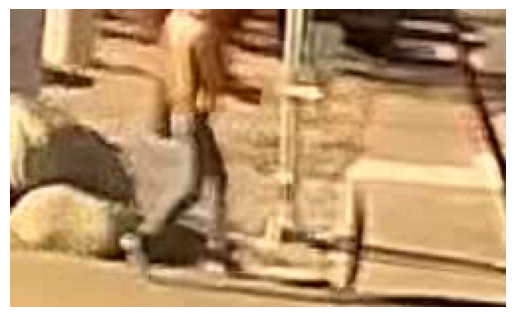

In [3]:
# plot one frame
plt.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
# hide the x and y axis
plt.axis('off')
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\single_frame.png')
plt.show()

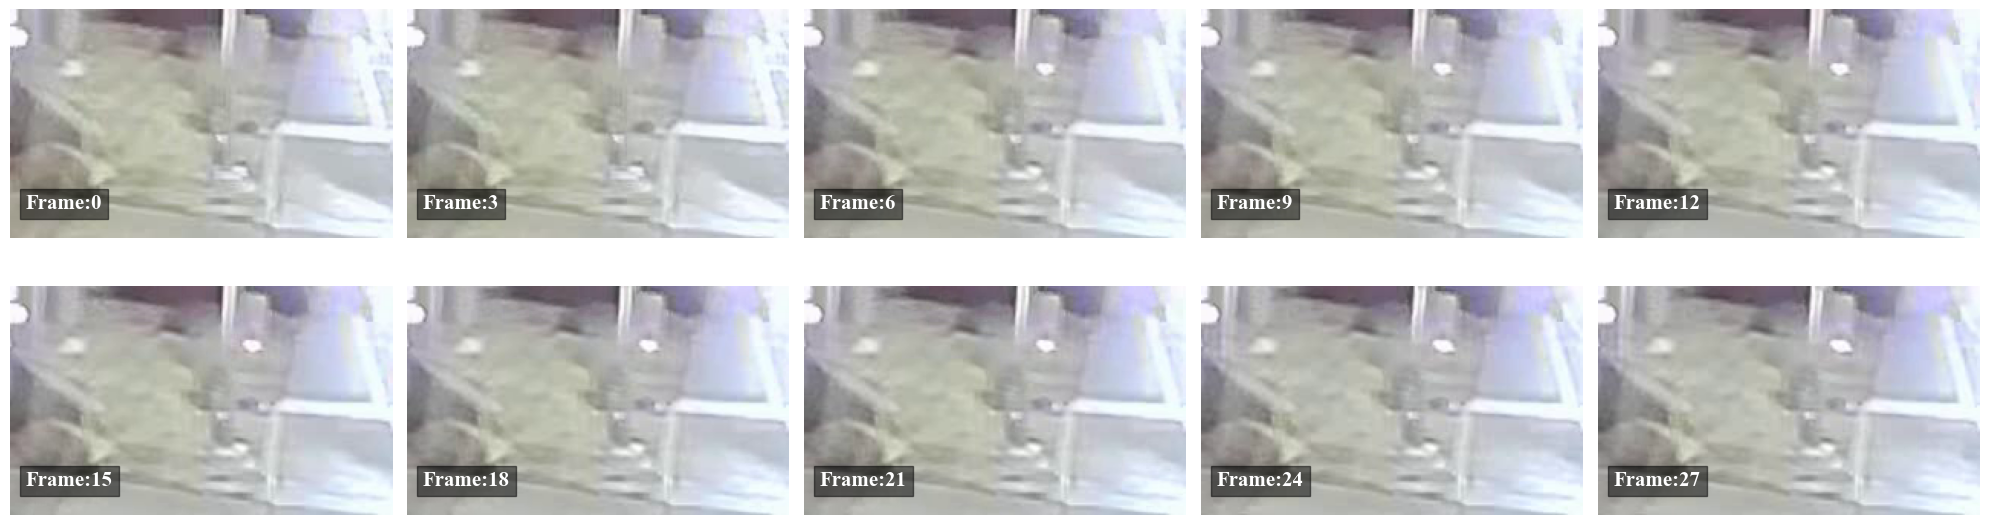

In [66]:
# plot all frames in 2 x 5 grid, with 3 frame step
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i, ax in enumerate(axs.flat):
    ax.imshow(cv2.cvtColor(frames[i * 3], cv2.COLOR_BGR2RGB))
    ax.axis('off')
    # annotate frame number in bottom of each frame
    ax.annotate(f'Frame:{i*3}', (10, 130), color='white', weight='bold', fontsize=15,
                bbox=dict(facecolor='black', alpha=0.5))
# make row 1 and 2 closer
plt.subplots_adjust(hspace=-0.7)
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\frames_dynamic_background.png',dpi = 300)
plt.tight_layout()
plt.show()

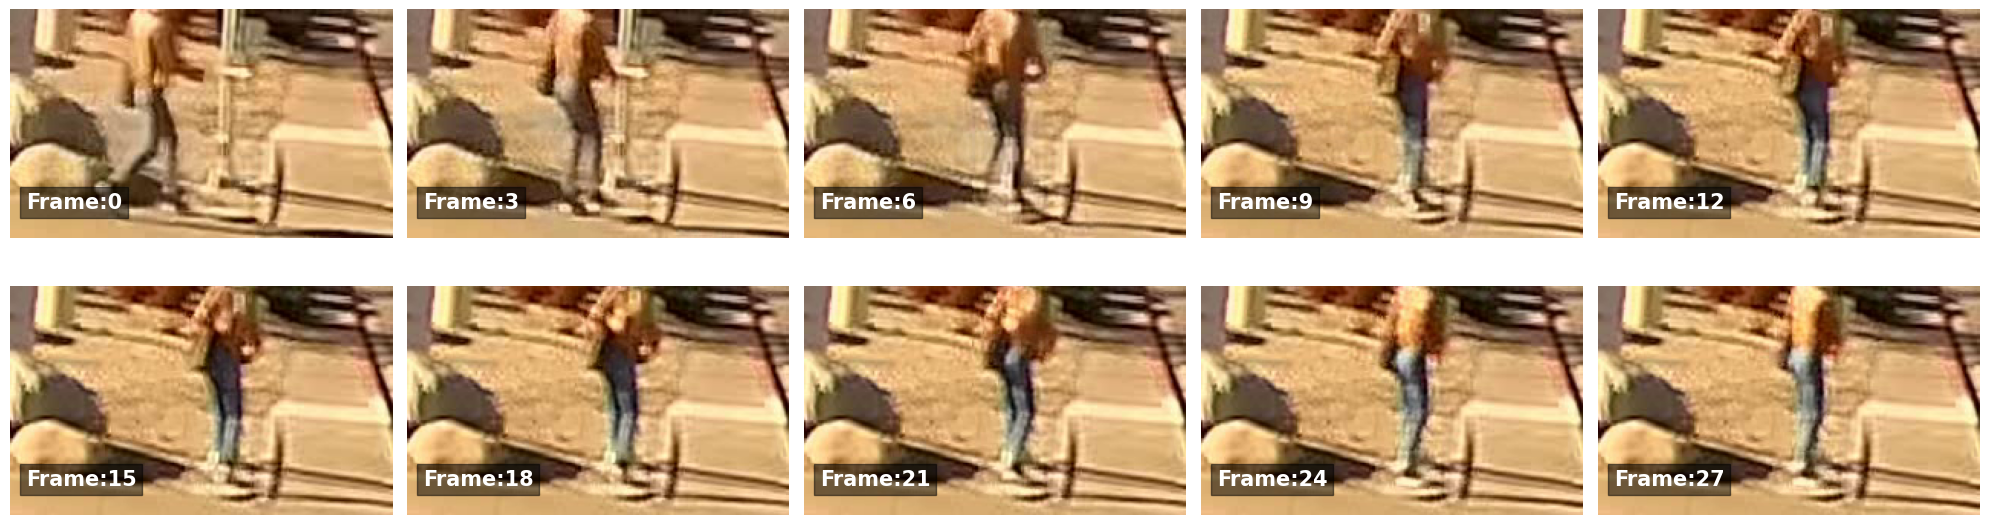

In [4]:
# plot all frames in 2 x 5 grid, with 3 frame step
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i, ax in enumerate(axs.flat):
    ax.imshow(cv2.cvtColor(frames[i * 3], cv2.COLOR_BGR2RGB))
    ax.axis('off')
    # annotate frame number in bottom of each frame
    ax.annotate(f'Frame:{i*3}', (10, 130), color='white', weight='bold', fontsize=15,
                bbox=dict(facecolor='black', alpha=0.5))
# make row 1 and 2 closer
plt.subplots_adjust(hspace=-0.7)
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\frames_pushed.png',dpi = 300)
plt.tight_layout()

plt.show()

In [7]:
# Custom Transform for Normalization
def create_data_loaders(train_dir, val_dir, batch_size=4, preprocess=None, augmentation=None):
    train_dataset = VideoDataset(train_dir, preprocess=preprocess, augmentation=augmentation)
    val_dataset = VideoDataset(val_dir, preprocess=preprocess)
    # test_dataset = VideoDataset(test_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support


In [5]:
model_path = r"D:\LiDAR_Data\2ndPHB\Video\overall_0123_FocalLoss_250x150_3class_256_Left_3CNN\model\best_model.pth"
num_classes = 3
model_L = CNNLSTMWithAttention(cnn_output_dim=256,
    lstm_hidden_dim=256,
    lstm_layers=1,
    num_classes = 3).to(device)
model_L.load_state_dict(torch.load(model_path,weights_only=True))
model_path = r"D:\LiDAR_Data\2ndPHB\Video\overall_0123_FocalLoss_250x150_3class_256_Right_3CNN\model\best_model.pth"
model_R = CNNLSTMWithAttention(cnn_output_dim=256,
    lstm_hidden_dim=256,
    lstm_layers=1,
    num_classes = 3).to(device)
model_R.load_state_dict(torch.load(model_path,weights_only=True))
models = [model_L, model_R]

In [428]:
# plot graph of confusion matrix 
import seaborn as sns

In [451]:
train_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_R\train'
test_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_R\test'
train_loader, val_loader = create_data_loaders(train_dir, test_dir, batch_size=2, preprocess=preprocessing, augmentation=transform_aug)
# cnn_output_dim=512
# lstm_hidden_dim=512
# lstm_layers=1
# num_classes = 3
# model = CNNLSTMWithAttention(cnn_output_dim=cnn_output_dim, lstm_hidden_dim=lstm_hidden_dim, lstm_layers=lstm_layers).to(device)
# model = CNNLSTM(cnn_output_dim=cnn_output_dim, lstm_hidden_dim=lstm_hidden_dim, lstm_layers=lstm_layers).to(device)
# model_path = r"D:\LiDAR_Data\2ndPHB\Video\overall_0123_FocalLoss_250x150_3class_512_Right_3CNN\model\best_model.pth"
# model_L.load_state_dict(torch.load(model_path,weights_only=True))
# model_L.eval()
y_true = []
y_pred = []
with torch.no_grad():
    with tqdm(total=len(val_loader), desc="Validation") as pbar:
        for inputs, labels, _ in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs, attention_weights = model_R(inputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(torch.argmax(outputs,dim=1).cpu().numpy())
            pbar.update(1)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
precision, recall, F1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=list(range(num_classes)))



Validation: 100%|██████████| 1052/1052 [01:35<00:00, 11.05it/s]


In [453]:
precision, recall, F1

(array([0.99070632, 0.98477157, 0.98976109]),
 array([0.999375  , 0.94634146, 0.96989967]),
 array([0.99502178, 0.96517413, 0.97972973]))

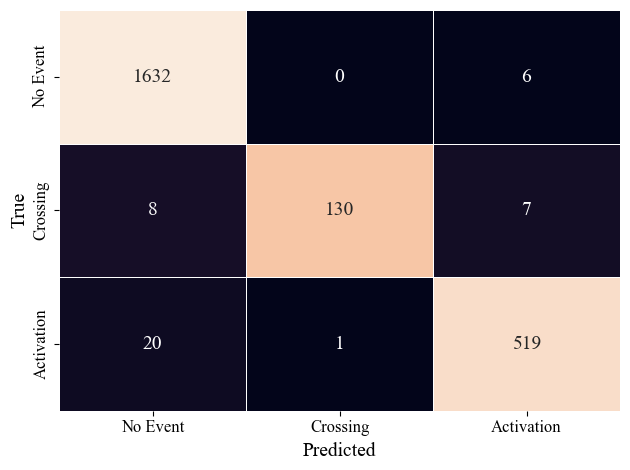

In [449]:
# Normalize the confusion matrix by row
cm_normalized = cm / cm.sum(axis=1, keepdims=True)

# Create the heatmap: colors based on the normalized values, but annotations are the original counts.
sns.heatmap(cm_normalized, annot=cm, fmt="d", cmap='rocket', cbar=False,
            annot_kws={"size": 14}, linewidths=0.5)

# Set the labels and ticks
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.xticks([0.5, 1.5, 2.5], ['No Event', 'Crossing', 'Activation'], fontsize=12)
plt.yticks([0.5, 1.5, 2.5], ['No Event', 'Crossing', 'Activation'], fontsize=12)
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\confusion_matrix_L_512.png',dpi = 300)
plt.show()

In [22]:
test_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_L\test'
val_dataset = VideoDataset(test_dir, preprocess=preprocessing)
val_dataset_raw = VideoDataset(test_dir)
activation_ind = []
for i in tqdm(range(0, len(val_dataset))):
    frames,label,location = val_dataset[i]
    if label == 2:
        activation_ind.append(i)
    # frames = frames.unsqueeze(0).to(device)
    # output,attention_weights = model(frames)

100%|██████████| 2323/2323 [01:07<00:00, 34.51it/s]


In [41]:
frames_raw.shape

(30, 150, 250, 3)

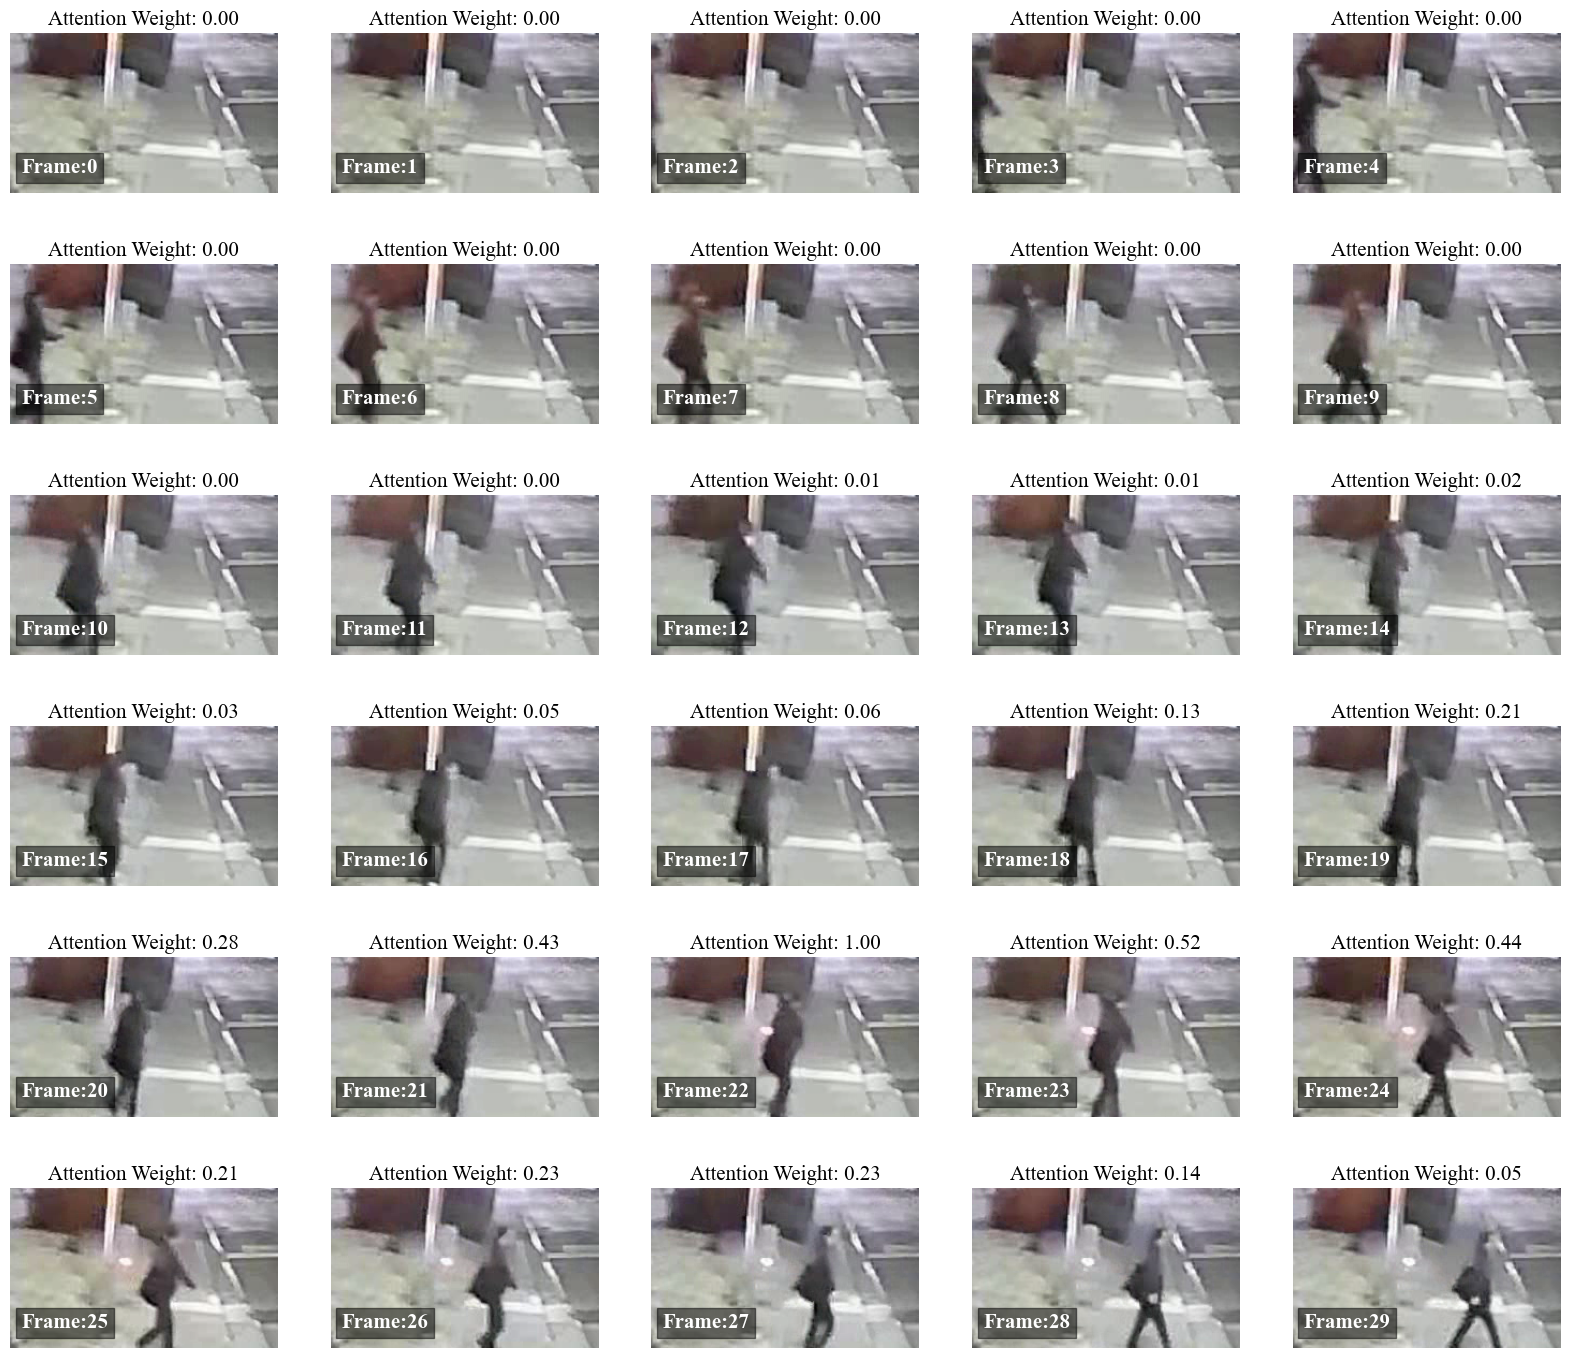

In [49]:
i = activation_ind[80]
frames,label,location = val_dataset[i]
frames = frames.unsqueeze(0).to(device)
output,attention_weights = model_L(frames)
attention_weights_numpy = attention_weights.squeeze(0).cpu().detach().numpy().flatten()
# normalize attention weights
attention_weights_numpy = attention_weights_numpy / attention_weights_numpy.max()
frames_raw,label,location = val_dataset_raw[i]
# plot frames with attention weights
fig, axs = plt.subplots(6, 5, figsize=(20, 20))
for i, ax in enumerate(axs.flat):
    temp = frames_raw[i]
    # normalize temp to [0, 1]
    temp = (temp - temp.min()) / (temp.max() - temp.min())
    ax.imshow(temp)
    ax.axis('off')
    ax.annotate(f'Frame:{i}', (10, 130), color='white', weight='bold', fontsize=15,
                bbox=dict(facecolor='black', alpha=0.5))
    ax.set_title(f'Attention Weight: {attention_weights_numpy[i]:.2f}', fontsize=15)
plt.subplots_adjust(hspace=-0.4)
plt.show()

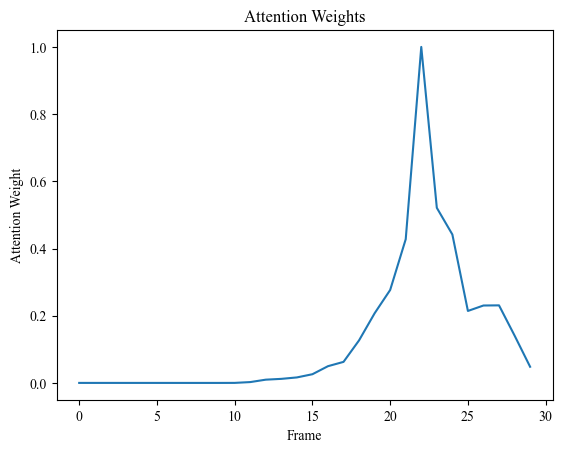

In [50]:
plt.plot(attention_weights_numpy)
plt.xlabel('Frame')
plt.ylabel('Attention Weight')
plt.title('Attention Weights')
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\attention_weights.png')
plt.show()

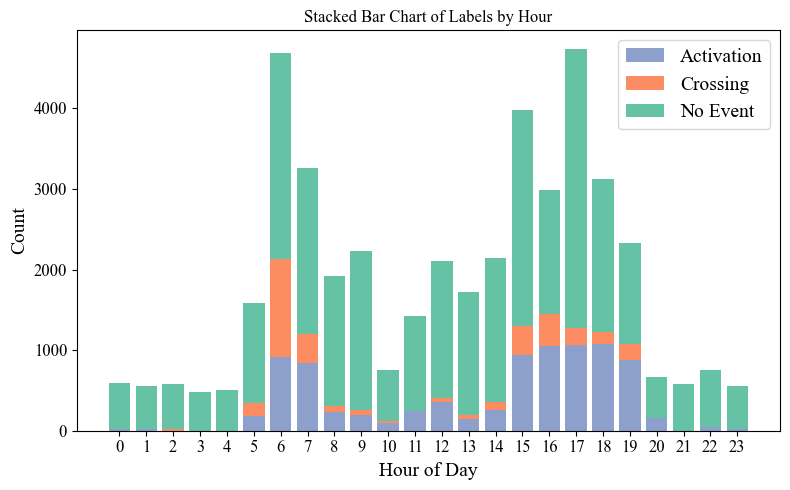

In [ ]:
data_dir = r'D:\LiDAR_Data\2ndPHB\Video\Clips'
data_list = os.listdir(data_dir)
labels = []
hours = []
locations = []
for data in data_list:
    label = data.split('_')[0]
    if label == '0':
        label = 'No Event'
    elif label == '1':
        label = 'Crossing'
    else:
        label = 'Activation'
    labels.append(label)
    date = data.split('_')[1]
    location = data.split('_')[3][0]
    locations.append(location)
    # convert hour to datetime
    # date = datetime.strptime(date, '%Y-%m-%d-%H-%M-%S')
    hours.append(int(date[11:13]))
df = pd.DataFrame({'label': labels, 'hour': hours, 'location': locations})
# Aggregate the data: count of each label per hour
counts = df.groupby(['hour', 'label']).size().unstack(fill_value=0)
counts = counts.sort_index()  # ensure hours are sorted

# Define an attractive color palette from Seaborn (Set2)
palette = sns.color_palette("Set2", 3)
colors = {'No Event': palette[0], 'Crossing': palette[1], 'Activation': palette[2]}

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8, 5))

# Start with a baseline of zeros
bottom = np.zeros(len(counts))

# Plot each label's contribution in the stacked bar
for label in sorted(counts.columns):
    values = counts[label].values
    ax.bar(counts.index, values, bottom=bottom, color=colors[label],
           label=f'{label}', width=0.8)
    bottom += values  # update the bottom for stacking

# Add labels and title
ax.set_xlabel('Hour of Day', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Stacked Bar Chart of Labels by Hour')
ax.legend(fontsize = 14)
ax.set_xticks(range(24))
ax.set_xticklabels(range(24))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\total_data_distribution.png')
plt.show()


In [407]:
# count number of labels in each location and dataset
test_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_L\test'
val_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_L\valid'
train_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_L\train'
test_dataset = VideoDataset(test_dir)
val_dataset = VideoDataset(val_dir)
train_dataset = VideoDataset(train_dir)
test_labels = []
val_labels = []
train_labels = []
for i in range(len(test_dataset)):
    _, label, _ = test_dataset[i]
    test_labels.append(label)
for i in range(len(val_dataset)):
    _, label, _ = val_dataset[i]
    val_labels.append(label)
for i in range(len(train_dataset)):
    _, label, _ = train_dataset[i]
    train_labels.append(label)

test_labels = np.array(test_labels)
val_labels = np.array(val_labels)
train_labels = np.array(train_labels)
test_counts = np.bincount(test_labels)
val_counts = np.bincount(val_labels)
train_counts = np.bincount(train_labels)


In [416]:
# count number of labels in each location and dataset
test_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_R\test'
val_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_R\valid'
train_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_R\train'
test_dataset = VideoDataset(test_dir)
val_dataset = VideoDataset(val_dir)
train_dataset = VideoDataset(train_dir)
test_labels = []
val_labels = []
train_labels = []
for i in range(len(test_dataset)):
    _, label, _ = test_dataset[i]
    test_labels.append(label)
for i in range(len(val_dataset)):
    _, label, _ = val_dataset[i]
    val_labels.append(label)
for i in range(len(train_dataset)):
    _, label, _ = train_dataset[i]
    train_labels.append(label)

test_labels = np.array(test_labels)
val_labels = np.array(val_labels)
train_labels = np.array(train_labels)
test_counts = np.bincount(test_labels)
val_counts = np.bincount(val_labels)
train_counts = np.bincount(train_labels)


In [420]:
training_curve_dir = r'D:\LiDAR_Data\2ndPHB\Video\overall_0128_FocalLoss_250x150_3class_256_Left_3CNN\curves\training_curves.pth'
training_curves = torch.load(training_curve_dir)

C:\Users\zhChe\AppData\Local\Temp\ipykernel_12460\1236079437.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_curves = torch.load(training_curve_dir)


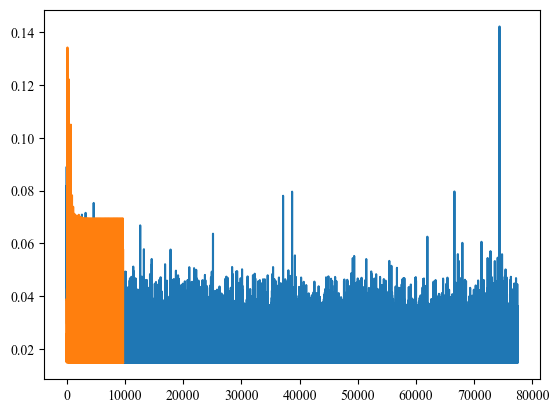

In [426]:
plt.plot(training_curves['train'])
plt.plot(training_curves['val'])

In [51]:
OutFolder =r'D:\LiDAR_Data\2ndPHB\Video\total_predictions_0124'
OutList = os.listdir(OutFolder)
for file in OutList:
    df = pd.read_csv(os.path.join(OutFolder,file))
    if (df.Left_Activating > 0.9).sum()/len(df) > 0.8:
        print(file,'L')
    if (df.Right_Activating > 0.9).sum()/len(df) > 0.8:
        print(file,'R')

00_00_192.168.1.108_1_20241206_094500.csv R
00_00_192.168.1.108_1_20241208_094500.csv R


In [204]:
def get_status(df):
    threshold = 0.9
    status = []
    for row in df.iterrows():
        row = row[1]
        if row.Left_Activating > threshold:
            status.append('Activating')
        elif row.Left_Crossing > threshold:
            status.append('Crossing')
        else:
            status.append('Normal')
    df['status_left'] = status
    status = []
    for row in df.iterrows():
        row = row[1]
        if row.Right_Activating > threshold:
            status.append('Activating')
        elif row.Right_Crossing > threshold:
            status.append('Crossing')
        else:
            status.append('Normal')
    df['status_right'] = status
    return df
def get_activation_summary(df, record_time, location = 'Left'):
    timet_delta = np.array([timedelta(seconds=int(i / 10)+3) for i in range(len(df))])
    df['timestamp'] = record_time + timet_delta
# identify the timestamp when the status changes from normal to activating or normal to crossing
    status_change = []
    event_type = []
    if location == 'Left':
        for i in range(1, len(df)):
            if df.status_left[i] != df.status_left[i - 1]:
                if df.status_left[i] != 'Normal':
                    status_change.append(df.timestamp[i])
                    event_type.append(df.status_left[i])
    elif location == 'Right':
        for i in range(1, len(df)):
            if df.status_right[i] != df.status_right[i - 1]:
                if df.status_right[i] != 'Normal':
                    status_change.append(df.timestamp[i])
                    event_type.append(df.status_right[i])
    status_change = np.array(status_change)
    event_type = np.array(event_type)
    summary = pd.DataFrame({'timestamp': status_change, 'event_type': event_type})
# if same event type happens within 5 seconds, keep the first one
    drop_inds = []
    for i in range(1, len(summary)):
        if summary.event_type[i] == summary.event_type[i - 1]:
            if summary.timestamp[i] - summary.timestamp[i - 1] < timedelta(seconds=10):
                drop_inds.append(i)
    summary = summary.drop(drop_inds)
    summary = summary.reset_index(drop=True)
    return summary

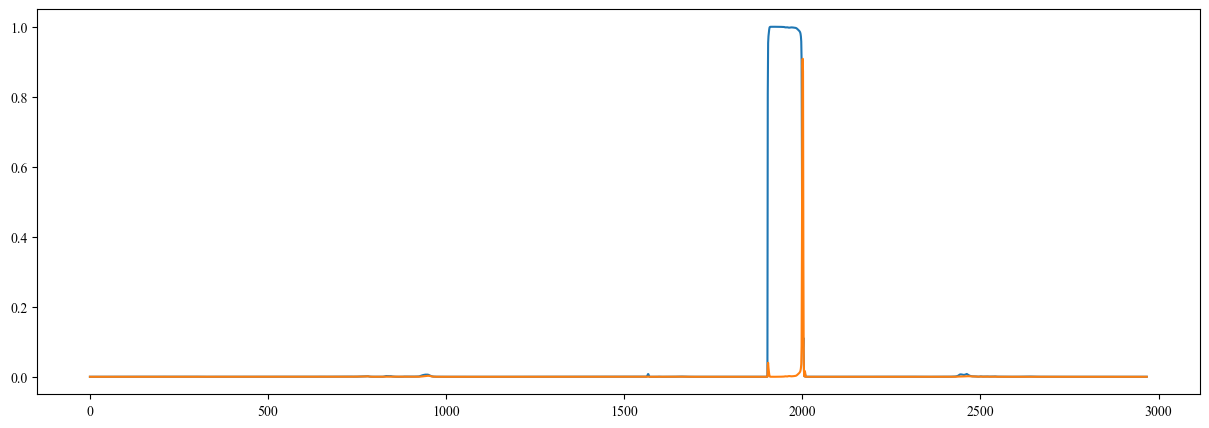

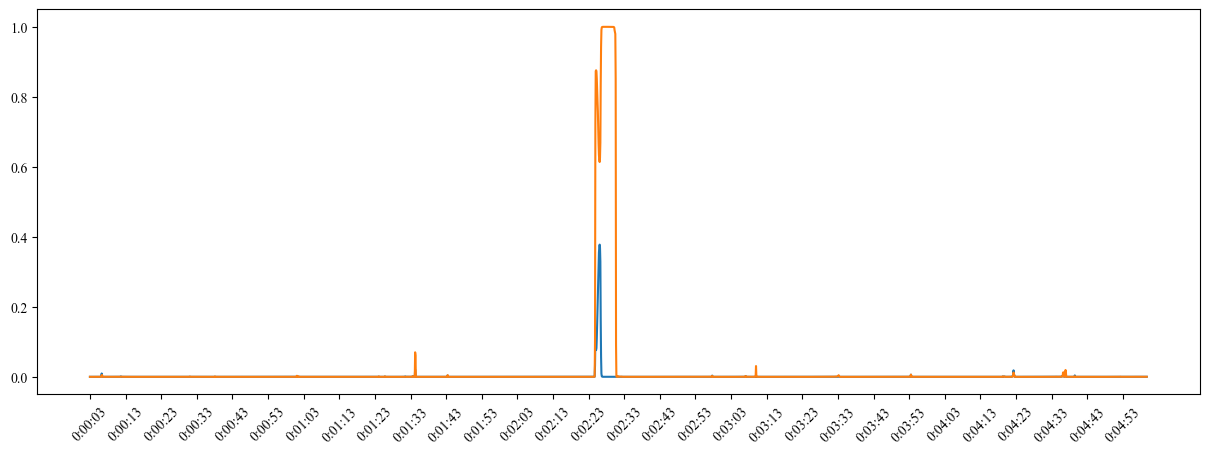

In [215]:
i = 304
df = pd.read_csv(os.path.join(OutFolder,OutList[i]))
date_str = OutList[i][22:-4]
record_time = datetime.strptime(date_str, '%Y%m%d_%H%M%S') 
plt.figure(figsize=(15, 5))
df.Left_Activating.plot()
df.Left_Crossing.plot()
plt.figure(figsize=(15, 5))
df.Right_Activating.plot()
df.Right_Crossing.plot()
# tick, convert frame to time
timestamp = np.array([str(timedelta(seconds=int(i / 10)+3)) for i in range(len(df))])
plt.xticks(range(0, len(df), 100), timestamp[::100], rotation=45)
plt.show()

df = get_status(df)
summary_left = get_activation_summary(df, record_time, location = 'Left')
summary_right = get_activation_summary(df, record_time, location = 'Right')

In [372]:
OutDir = r'D:\LiDAR_Data\2ndPHB\Video\EvaluationRes_0202'
StatusSumFolder = os.path.join(OutDir, 'StatusSummary')
os.makedirs(StatusSumFolder, exist_ok=True)
ActivationSumLeftFolder = os.path.join(OutDir, 'ActivationSummaryLeft')
os.makedirs(ActivationSumLeftFolder, exist_ok=True)
ActivationSumRightFolder = os.path.join(OutDir, 'ActivationSummaryRight')
os.makedirs(ActivationSumRightFolder, exist_ok=True)
# convert OutList to date 
date_list = []
for file in OutList:
    date_str = file[22:-4]
    # '20241208_235500'
    date = datetime.strptime(date_str, '%Y%m%d_%H%M%S')
    date_list.append(date)
date_list = np.array(date_list)
OutList = np.array(OutList)
# sort OutList by date
OutList = OutList[np.argsort(date_list)]
for file in tqdm(OutList):
    df = pd.read_csv(os.path.join(OutFolder,file))
    df = get_status(df)
    record_time = datetime.strptime(file[22:-4], '%Y%m%d_%H%M%S')
    summary_left = get_activation_summary(df, record_time, location = 'Left')
    summary_right = get_activation_summary(df, record_time, location = 'Right')
    df.to_csv(os.path.join(StatusSumFolder,file),index = False)
    summary_left.to_csv(os.path.join(ActivationSumLeftFolder,file),index = False)
    summary_right.to_csv(os.path.join(ActivationSumRightFolder,file),index = False)

100%|██████████| 1236/1236 [07:15<00:00,  2.84it/s]


In [374]:
ActivationSumLeftFolder = os.path.join(OutDir, 'ActivationSummaryLeft')
summary_list = os.listdir(ActivationSumLeftFolder)
total_summary_left = []
for file in tqdm(summary_list):
    df = pd.read_csv(os.path.join(ActivationSumLeftFolder,file))
    total_summary_left.append(df)
total_summary_left = pd.concat(total_summary_left)
total_summary_left.timestamp = pd.to_datetime(total_summary_left.timestamp)
# sort by timestamp
total_summary_left = total_summary_left.sort_values(by='timestamp')
total_summary_left = total_summary_left.reset_index(drop=True)
total_summary_left.to_csv(os.path.join(OutDir,'total_summary_left.csv'),index = False)

ActivationSumRightFolder = os.path.join(OutDir, 'ActivationSummaryRight')
summary_list = os.listdir(ActivationSumRightFolder)
total_summary_right = []
for file in tqdm(summary_list):
    df = pd.read_csv(os.path.join(ActivationSumRightFolder,file))
    total_summary_right.append(df)
total_summary_right = pd.concat(total_summary_right)
total_summary_right.timestamp = pd.to_datetime(total_summary_right.timestamp)
total_summary_right = total_summary_right.reset_index(drop=True)
# sort by timestamp
total_summary_right = total_summary_right.sort_values(by='timestamp')
total_summary_right.to_csv(os.path.join(OutDir,'total_summary_right.csv'),index = False)

100%|██████████| 1236/1236 [00:06<00:00, 180.07it/s]


In [370]:
# identify dependant crossing events
dependant_crossin_inds = []
for i in range(1,len(total_summary_left)):
    if total_summary_left.event_type[i] == 'Crossing':
        if total_summary_left.event_type[i-1] == 'Activating':
            if total_summary_left.timestamp[i] - total_summary_left.timestamp[i-1] < timedelta(seconds=12):
                dependant_crossin_inds.append(i)
total_summary_left = total_summary_left.drop(dependant_crossin_inds)
total_summary_left = total_summary_left.reset_index(drop=True)
total_summary_left.to_csv(os.path.join(OutDir,'total_summary_left.csv'),index = False)
dependant_crossin_inds = []
for i in range(1,len(total_summary_right)):
    if total_summary_right.event_type[i] == 'Crossing':
        if total_summary_right.event_type[i-1] == 'Activating':
            if total_summary_right.timestamp[i] - total_summary_right.timestamp[i-1] < timedelta(seconds=12):
                dependant_crossin_inds.append(i)
total_summary_right = total_summary_right.drop(dependant_crossin_inds)
total_summary_right = total_summary_right.reset_index(drop=True)
total_summary_right.to_csv(os.path.join(OutDir,'total_summary_right.csv'),index = False)


In [364]:
evluation_table = pd.read_excel(r'D:\LiDAR_Data\2ndPHB\Video\HAWK Pedestrian Behavior Compiled Data.xlsx')
evluation_table = evluation_table.iloc[150:766]
evluation_table = evluation_table.reset_index(drop=True)
evluation_table_left = evluation_table[evluation_table['Bound'] == 'N'].copy()
evluation_table_right = evluation_table[evluation_table['Bound'] == 'S'].copy()
timestamp = evluation_table_left['Date'].astype(str) + '_' + evluation_table_left['Time'].astype(str)
timestamp = timestamp.str.replace(':','')
timestamp = timestamp.str.replace('-','')
# convert to datetime
timestamp = pd.to_datetime(timestamp, format='%Y%m%d_%H%M%S')
evluation_table_left['timestamp'] = timestamp

timestamp = evluation_table_right['Date'].astype(str) + '_' + evluation_table_right['Time'].astype(str)
timestamp = timestamp.str.replace(':','')
timestamp = timestamp.str.replace('-','')
# convert to datetime
timestamp = pd.to_datetime(timestamp, format='%Y%m%d_%H%M%S')
evluation_table_right['timestamp'] = timestamp


In [375]:
total_summary_left_eva = total_summary_left.loc[(total_summary_left.timestamp < datetime(2024,12,6,0,0,0) ) & (total_summary_left.timestamp > datetime(2024,12,5,0,0,0))].copy()
total_summary_right_eva = total_summary_right.loc[(total_summary_right.timestamp < datetime(2024,12,6,0,0,0) ) & (total_summary_right.timestamp > datetime(2024,12,5,0,0,0))].copy()


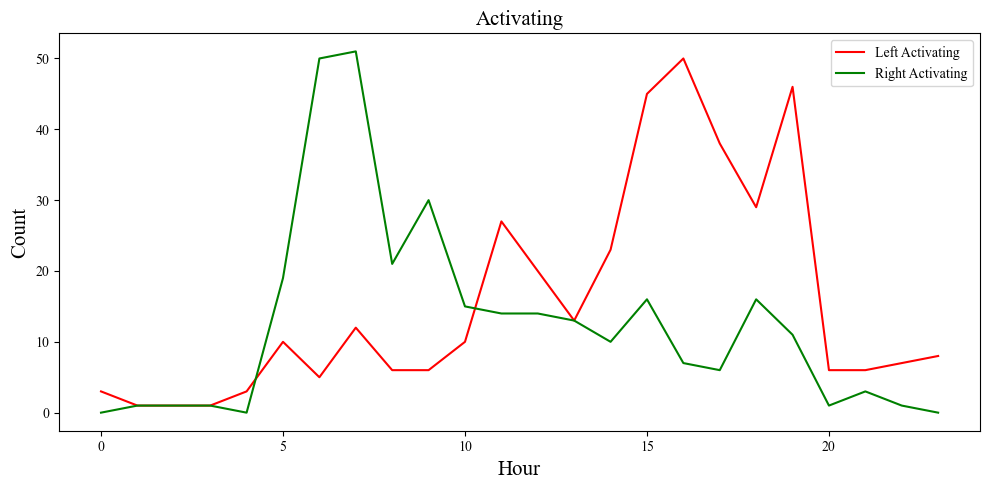

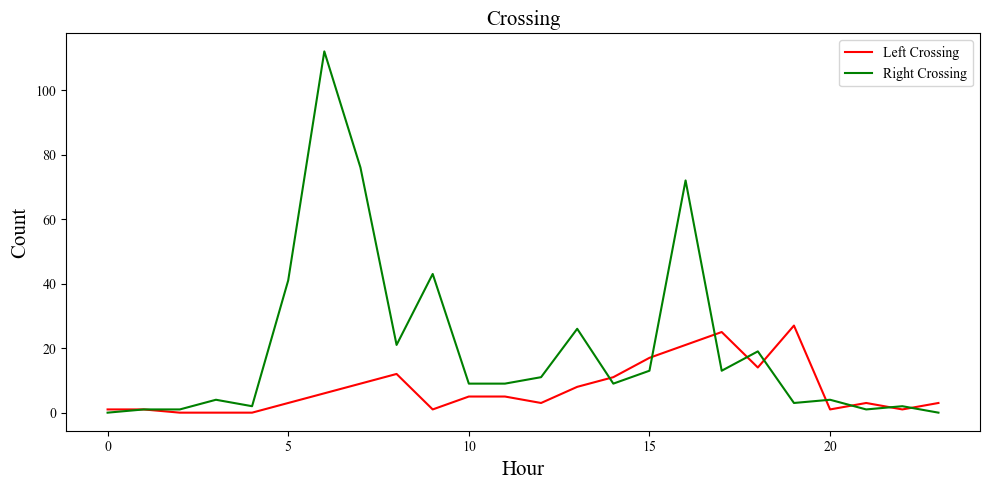

In [376]:
activating_left_count = np.zeros(24)
crossing_left_count = np.zeros(24)
activating_right_count = np.zeros(24)
crossing_right_count = np.zeros(24)
for i in range(24):
    activating_left_count[i] = (total_summary_left_eva.event_type == 'Activating').loc[total_summary_left_eva.timestamp.dt.hour == i].sum()
    crossing_left_count[i] = (total_summary_left_eva.event_type == 'Crossing').loc[total_summary_left_eva.timestamp.dt.hour == i].sum()
    activating_right_count[i] = (total_summary_right_eva.event_type == 'Activating').loc[total_summary_right_eva.timestamp.dt.hour == i].sum()
    crossing_right_count[i] = (total_summary_right_eva.event_type == 'Crossing').loc[total_summary_right_eva.timestamp.dt.hour == i].sum()
# plot the activating and crossing count
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(24), activating_left_count, label='Left Activating', color='r')
ax.plot(range(24), activating_right_count, label='Right Activating', color='g')
ax.set_xlabel('Hour', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Activating', fontsize=15)
ax.legend()
plt.tight_layout()
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\activating_crossing_count.png',dpi = 300)
plt.show()
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(24), crossing_left_count, label='Left Crossing', color='r')
ax.plot(range(24), crossing_right_count, label='Right Crossing', color='g')
ax.set_xlabel('Hour', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Crossing', fontsize=15)
ax.legend()
plt.tight_layout()
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\activating_crossing_count.png',dpi = 300)
plt.show()


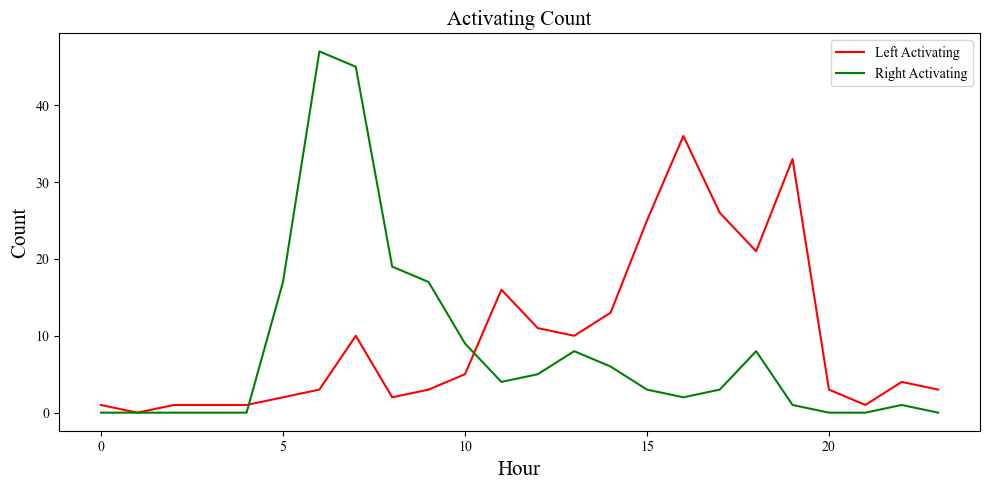

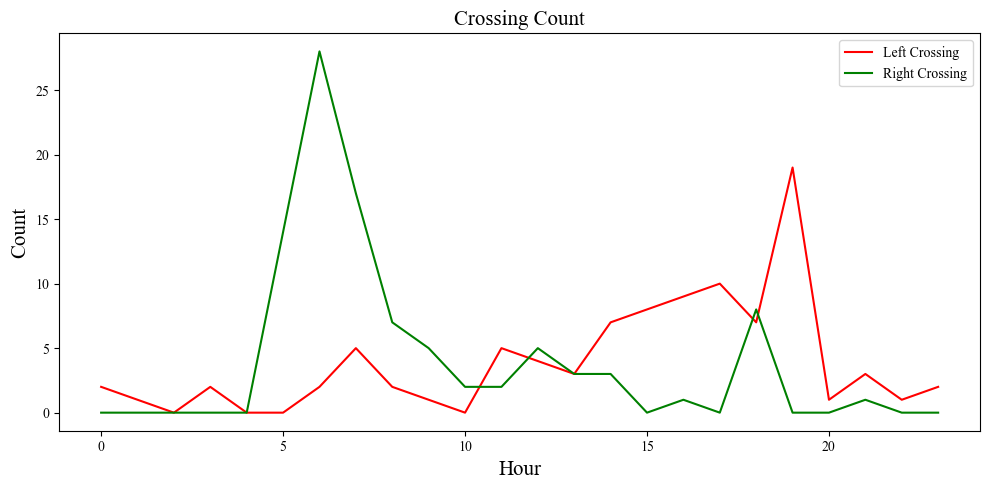

In [377]:
activating_left_count = np.zeros(24)
crossing_left_count = np.zeros(24)
activating_right_count = np.zeros(24)
crossing_right_count = np.zeros(24)
for i in range(24):
    activating_left_count[i] = (evluation_table_left['Pressed?'] == 'Y').loc[evluation_table_left.timestamp.dt.hour == i].sum()
    crossing_left_count[i] = (evluation_table_left['Pressed?'] == 'N').loc[evluation_table_left.timestamp.dt.hour == i].sum()
    activating_right_count[i] = (evluation_table_right['Pressed?'] == 'Y').loc[evluation_table_right.timestamp.dt.hour == i].sum()
    crossing_right_count[i] = (evluation_table_right['Pressed?'] == 'N').loc[evluation_table_right.timestamp.dt.hour == i].sum()
# plot the activating and crossing count
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(24), activating_left_count, label='Left Activating', color='r')
ax.plot(range(24), activating_right_count, label='Right Activating', color='g')
ax.set_xlabel('Hour', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Activating Count', fontsize=15)
ax.legend()
plt.tight_layout()
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\activating_crossing_count.png',dpi = 300)
plt.show()
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(24), crossing_left_count, label='Left Crossing', color='r')
ax.plot(range(24), crossing_right_count, label='Right Crossing', color='g')
ax.set_xlabel('Hour', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Crossing Count', fontsize=15)
ax.legend()
plt.tight_layout()
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\activating_crossing_count.png',dpi = 300)
plt.show()


In [275]:
evluation_table_left

Event ID  # of Pedestrians Pressed?       Date      Time Bound  \
0         1.0               1.0        Y 2024-12-04  17:00:47     N   
1         2.0               1.0        Y 2024-12-04  17:01:57     N   
2         3.0               1.0        N 2024-12-04  17:02:03     N   
3         4.0               1.0        Y 2024-12-04  17:04:29     N   
4         5.0               1.0        Y 2024-12-04  17:05:23     N   
..        ...               ...      ...        ...       ...   ...   
134     135.0               1.0        Y 2024-12-04  22:25:53     N   
135     136.0               1.0        N 2024-12-04  22:29:06     N   
136     137.0               1.0        Y 2024-12-04  22:31:13     N   
137     138.0               1.0        N 2024-12-04  22:38:43     N   
138     139.0               2.0        Y 2024-12-04  22:42:29     N   

              timestamp  
0   2024-12-04 17:00:47  
1   2024-12-04 17:01:57  
2   2024-12-04 17:02:03  
3   2024-12-04 17:04:29  
4   2024-12-04 17:05:23  
..                  ...  
134 2024-12-04 22:25:53  
135 2024-12-04 22:29:06  
136 2024-12-04 22:31:13  
137 2024-12-04 22:38:43  
138 2024-12-04 22:42:29  

[121 rows x 7 columns]